<a href="https://colab.research.google.com/github/Sarvesh-39/Auction-/blob/main/Sarvesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediciting Real Estate Prices

Dataset: House Sales in King County, USA

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#Data Understanding & Preperation

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/IS675_project/kc_house_data.csv')

In [ ]:
print(df.head())

           id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     lo

In [ ]:
print(df.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [ ]:
print(df.shape)

(21613, 21)


<Axes: xlabel='bedrooms', ylabel='count'>

<Figure size 1200x800 with 0 Axes>

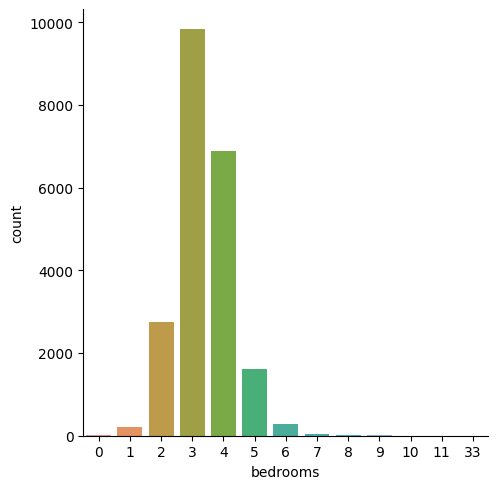

In [ ]:
# Visual exploration
plt.figure(figsize=(12,8))
sns.displot(df['price'])
sns.countplot(x=df['bedrooms'])

<Axes: xlabel='bedrooms', ylabel='price'>

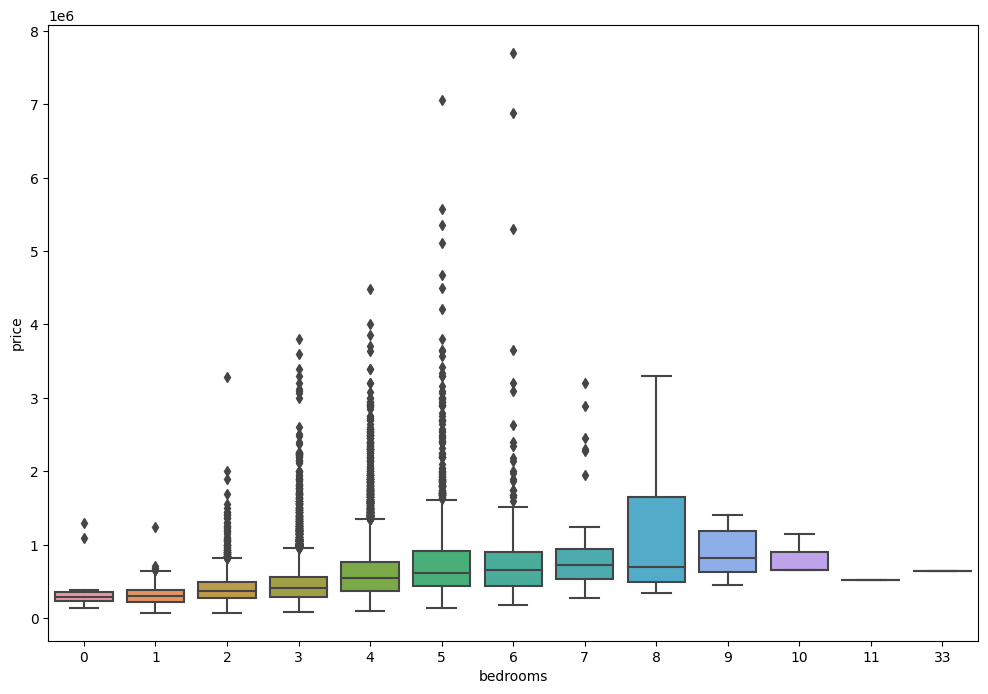

In [ ]:
plt.figure(figsize=(12,8))
sns.boxplot(x='bedrooms',y='price',data=df)

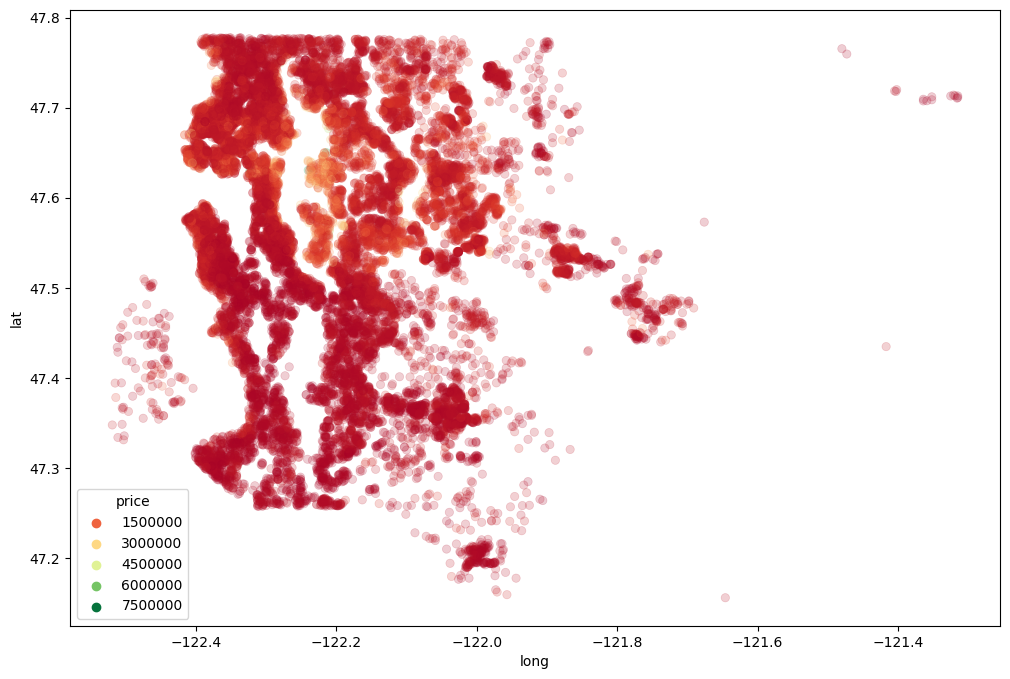

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='long',y='lat', data=df, hue='price', palette='RdYlGn', edgecolor=None, alpha=0.2)
plt.show()

<Axes: xlabel='price', ylabel='sqft_living'>

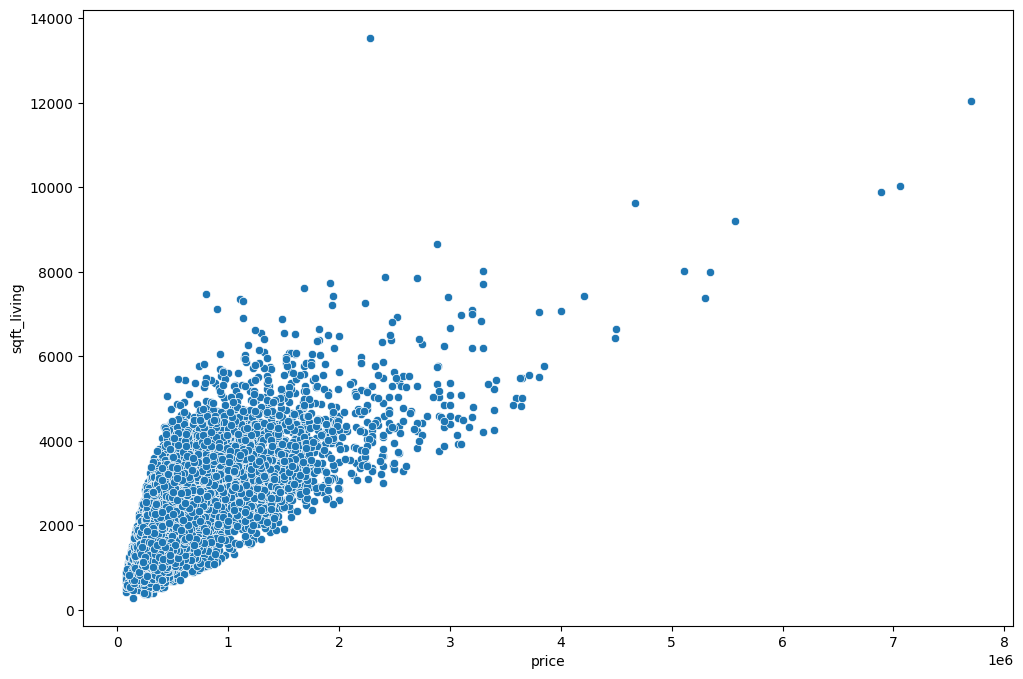

In [ ]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft_living',data=df)

In [ ]:
# Data Preparation
# We are converting 'date' to datetime and extracting month and year to view the trend of pricing over time
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].apply(lambda date: date.month)
df['year'] = df['date'].apply(lambda date: date.year)

<ipython-input-5-019016126923>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('year').mean()['price'].plot()


<Axes: xlabel='year'>

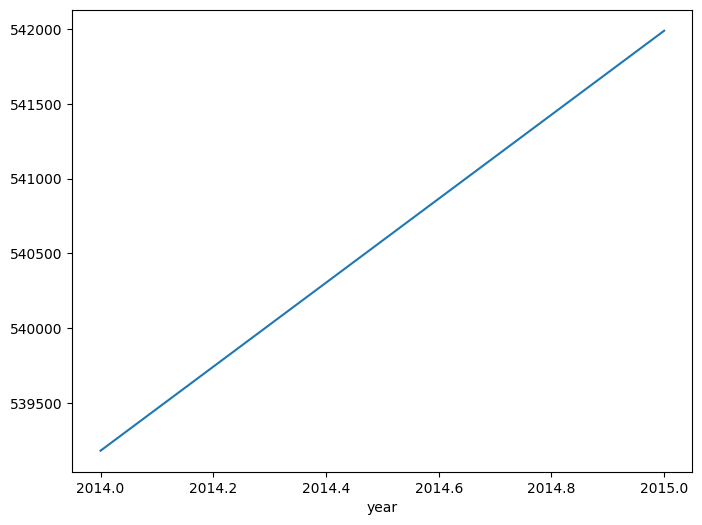

In [ ]:
plt.figure(figsize=(8,6))
df.groupby('year').mean()['price'].plot()

In [ ]:
# We are dropping the certain columns to minimize error and loss in our models
df = df.drop('date',axis=1)

In [ ]:
df = df.drop('zipcode',axis=1)

In [ ]:
df = df.drop('id',axis=1)

<Figure size 1200x800 with 0 Axes>

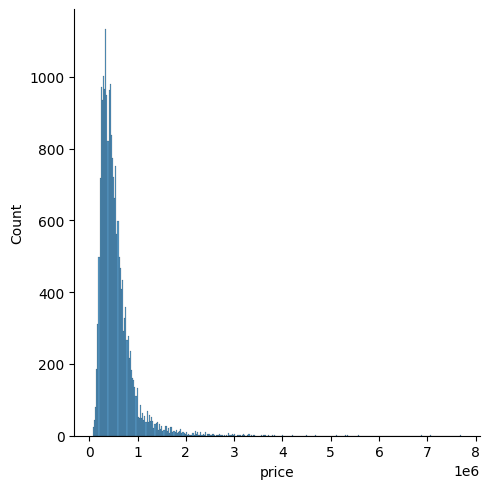

In [ ]:
plt.figure(figsize=(12,8))
sns.displot(df['price'])

To eliminate potential outliers we will only be keeping the major bulk of housing prices up to 1.5 million

In [ ]:
# Function used to return the outliers in housing prices
def outlier_detection(x, c = 1.5):
    q1, q3 = np.percentile(x, [25,75])

    iqr = (q3 - q1)

    lob = q1 - (iqr * c)

    uob = q3 + (iqr * c)

    indicies = np.where((x > uob) | (x < lob))

    return indicies

In [ ]:
# Detect and remove outliers
price_outliers = outlier_detection(df['price'])

print("Total Outliers Present & Removed  : ",len(price_outliers[0]))
df = df.drop(price_outliers[0])

Total Outliers Present & Removed  :  1146


In [ ]:
df.shape

(20467, 20)

In [ ]:
print(df.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month', 'year'],
      dtype='object')


In [ ]:
# Define the features and target variables going forward
X = df.drop('price', axis=1).values
y = df['price'].values

#Modeling

In [ ]:
# Spliting the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Neural Network Design

1) First Neural Network we will use is a simple Feedforward Neural Network

In [ ]:
# We must convert the numpy arrays into Tensors in Pytorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# Two TensorDatasets for the training and testing data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
# DataLoaders for both of the datasets
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
#Simple Feedforward Neural Network Architecture
class FeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#Training Model
def train_model(model, criterion, optimizer, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}')

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(target.view(-1).tolist())

    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R^2: {r2}')
    return mae, mse, rmse, r2

#Model Optimization: Feedforward Neural Network
- We will now begin to implement model optimization for our feedforward neural network

In [ ]:
# We are initializing the model
input_size = X_train.shape[1]
model_ff = FeedforwardNN(input_size)

In [ ]:
# Here we define the loss function and optimizer
criterion = nn.MSELoss()
optimizer_ff = torch.optim.Adam(model_ff.parameters(), lr=0.001)

In [ ]:
# Training the model
train_model(model_ff, criterion, optimizer_ff, train_loader, epochs=100)

Epoch 1, Training Loss: 313619546112.0
Epoch 2, Training Loss: 275791380480.0
Epoch 3, Training Loss: 187613396992.0
Epoch 4, Training Loss: 198055673856.0
Epoch 5, Training Loss: 137869049856.0
Epoch 6, Training Loss: 62825201664.0
Epoch 7, Training Loss: 44499189760.0
Epoch 8, Training Loss: 20971679744.0
Epoch 9, Training Loss: 25307213824.0
Epoch 10, Training Loss: 34578046976.0
Epoch 11, Training Loss: 20802146304.0
Epoch 12, Training Loss: 22288785408.0
Epoch 13, Training Loss: 31481786368.0
Epoch 14, Training Loss: 28828110848.0
Epoch 15, Training Loss: 35279392768.0
Epoch 16, Training Loss: 25238769664.0
Epoch 17, Training Loss: 36265095168.0
Epoch 18, Training Loss: 17367500800.0
Epoch 19, Training Loss: 28519886848.0
Epoch 20, Training Loss: 28608256000.0
Epoch 21, Training Loss: 19015016448.0
Epoch 22, Training Loss: 17204867072.0
Epoch 23, Training Loss: 29648979968.0
Epoch 24, Training Loss: 18485139456.0
Epoch 25, Training Loss: 18999158784.0
Epoch 26, Training Loss: 1774

In [ ]:
# Evaluating the model
mae_ff, mse_ff, rmse_ff, r2_ff = evaluate_model(model_ff, test_loader)
print(f'Model MAE: {mae_ff}, MSE: {mse_ff}, RMSE: {rmse_ff}, R^2:{r2_ff}')

MAE: 90085.14504807594, MSE: 14183361837.359861, RMSE: 119093.92023676046, R^2: 0.6634324152774431
Model MAE: 90085.14504807594, MSE: 14183361837.359861, RMSE: 119093.92023676046, R^2:0.6634324152774431


- Hyperparameter Tuning

In [ ]:
# The function we will use to create the model
def create_model(input_size):
    return FeedforwardNN(input_size)

In [ ]:
# Function we will use to train the model with our hyperparameters
def train_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs):
    model.train()

    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    mae, mse, rmse, r2 = evaluate_model(model, test_loader)
    return mae, mse, rmse, r2

In [ ]:
# We then will choose yperparameters to tune
learning_rates = [0.01, 0.001, 0.0001]
n_epochs_list = [50, 100, 150]

results = []

In [ ]:
# Loop for hyperparameter tuning
for lr in learning_rates:
    for epochs in n_epochs_list:
        model = create_model(X_train.shape[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        mae, mse, rmse, r2 = train_evaluate(model, train_loader, test_loader, optimizer, criterion, epochs)
        results.append((lr, epochs, mae, mse, rmse, r2))
        print(f'Learning Rate: {lr}, Epochs: {epochs}, MAE: {mae} ,MSE: {mse}, RMSE: {rmse}, R^2: {r2}')

MAE: 83456.20133026228, MSE: 12664024299.528774, RMSE: 112534.54713788461, R^2: 0.6994859103056226
Learning Rate: 0.01, Epochs: 50, MAE: 83456.20133026228 ,MSE: 12664024299.528774, RMSE: 112534.54713788461, R^2: 0.6994859103056226
MAE: 80823.89742372603, MSE: 12306538734.50896, RMSE: 110934.84003913721, R^2: 0.7079689522368361
Learning Rate: 0.01, Epochs: 100, MAE: 80823.89742372603 ,MSE: 12306538734.50896, RMSE: 110934.84003913721, R^2: 0.7079689522368361
MAE: 81088.55868852793, MSE: 12003271522.468948, RMSE: 109559.44287220955, R^2: 0.715165406381649
Learning Rate: 0.01, Epochs: 150, MAE: 81088.55868852793 ,MSE: 12003271522.468948, RMSE: 109559.44287220955, R^2: 0.715165406381649
MAE: 98688.08326972398, MSE: 16251072303.747335, RMSE: 127479.69369176934, R^2: 0.6143661695200744
Learning Rate: 0.001, Epochs: 50, MAE: 98688.08326972398 ,MSE: 16251072303.747335, RMSE: 127479.69369176934, R^2: 0.6143661695200744
MAE: 89798.81487962567, MSE: 14131596246.309498, RMSE: 118876.39061777362, R^

In [ ]:
# Results
print("Tuning Results:")
for res in results:
    print(f'Learning Rate: {res[0]}, Epochs: {res[1]}, MAE:{res[2]} MSE: {res[3]}, RMSE: {res[3]}, R^2: {res[4]}')

Tuning Results:
Learning Rate: 0.01, Epochs: 50, MAE:83456.20133026228 MSE: 12664024299.528774, RMSE: 12664024299.528774, R^2: 112534.54713788461
Learning Rate: 0.01, Epochs: 100, MAE:80823.89742372603 MSE: 12306538734.50896, RMSE: 12306538734.50896, R^2: 110934.84003913721
Learning Rate: 0.01, Epochs: 150, MAE:81088.55868852793 MSE: 12003271522.468948, RMSE: 12003271522.468948, R^2: 109559.44287220955
Learning Rate: 0.001, Epochs: 50, MAE:98688.08326972398 MSE: 16251072303.747335, RMSE: 16251072303.747335, R^2: 127479.69369176934
Learning Rate: 0.001, Epochs: 100, MAE:89798.81487962567 MSE: 14131596246.309498, RMSE: 14131596246.309498, R^2: 118876.39061777362
Learning Rate: 0.001, Epochs: 150, MAE:88854.72415552232 MSE: 13844816953.459103, RMSE: 13844816953.459103, R^2: 117664.00024416603
Learning Rate: 0.0001, Epochs: 50, MAE:396515.22246414976 MSE: 196479825321.94714, RMSE: 196479825321.94714, R^2: 443260.4486325699
Learning Rate: 0.0001, Epochs: 100, MAE:135409.53319390165 MSE: 307

- Recreating & Training Model with optimal hyperparameters

In [ ]:
Official_model = create_model(X_train.shape[1])

Official_optimizer = torch.optim.Adam(Official_model.parameters(), lr=0.01)

Official_criterion = nn.MSELoss()

In [ ]:
# Here we will begin timing our training model to capture the time it takes
start_time_ffnn = time.time()

# Training the new model
final_epochs = 150

for epoch in range(final_epochs):
    Official_model.train()

    for data, target in train_loader:

        Official_optimizer.zero_grad()
        output = Official_model(data)
        loss = Official_criterion(output, target)

        loss.backward()
        Official_optimizer.step()

    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}')

# End of the timer
end_time_ffnn = time.time()

Epoch 1, Training Loss: 20791508992.0
Epoch 2, Training Loss: 28427972608.0
Epoch 3, Training Loss: 34871508992.0
Epoch 4, Training Loss: 29247744000.0
Epoch 5, Training Loss: 14989137920.0
Epoch 6, Training Loss: 18512125952.0
Epoch 7, Training Loss: 14781045760.0
Epoch 8, Training Loss: 13700987904.0
Epoch 9, Training Loss: 19064469504.0
Epoch 10, Training Loss: 13895256064.0
Epoch 11, Training Loss: 12906464256.0
Epoch 12, Training Loss: 18813376512.0
Epoch 13, Training Loss: 19122313216.0
Epoch 14, Training Loss: 11487345664.0
Epoch 15, Training Loss: 14520310784.0
Epoch 16, Training Loss: 12427959296.0
Epoch 17, Training Loss: 13152649216.0
Epoch 18, Training Loss: 12940281856.0
Epoch 19, Training Loss: 15500699648.0
Epoch 20, Training Loss: 10423531520.0
Epoch 21, Training Loss: 10314178560.0
Epoch 22, Training Loss: 8465081344.0
Epoch 23, Training Loss: 11059444736.0
Epoch 24, Training Loss: 16911735808.0
Epoch 25, Training Loss: 16996334592.0
Epoch 26, Training Loss: 1503129497

In [ ]:
# We will now the calculate the training time by subtracting the end time for the start and storing it under ffnn_train_time to call it later
ffnn_train_time = end_time_ffnn - start_time_ffnn

In [ ]:
print(f"Neural Network Training Time: {ffnn_train_time} seconds")

Neural Network Training Time: 48.54102802276611 seconds


In [ ]:
# Evaluating the final model with the optimal hyperparameters
final_mae, final_mse, final_rmse, final_r2 = evaluate_model(Official_model, test_loader)
print(f'Final Model MAE: {final_mae}, MSE: {final_mse}, RMSE: {final_rmse}, R^2: {final_r2}')

MAE: 79341.17329635085, MSE: 11886895677.742262, RMSE: 109027.04103910306, R^2: 0.7179269757069509
Final Model MAE: 79341.17329635085, MSE: 11886895677.742262, RMSE: 109027.04103910306, R^2: 0.7179269757069509


#We will now create a second Neural Network
- This will also be a more complex feedforward neural network with a different architecture: increased layers, increased neurons, and includes dropout and regularization

In [ ]:
class ComplexFeedforwardNN(nn.Module):
    def __init__(self, input_size):
        super(ComplexFeedforwardNN, self).__init__()

        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
# Initializing the more complex feedforward neural network model
Complex_model = ComplexFeedforwardNN(input_size=X_train.shape[1])

In [ ]:
# Defining the loss function and optimizer for the new complex feedforward neural network model
Complex_criterion = nn.MSELoss()
Complex_optimizer = torch.optim.Adam(Complex_model.parameters(), lr=0.001)

In [ ]:
# Training loop for the complex feedforward neural network model
complex_epochs = 100
for epoch in range(complex_epochs):
    Complex_model.train()
    for data, target in train_loader:
        Complex_optimizer.zero_grad()
        output = Complex_model(data)
        loss = Complex_criterion(output, target)
        loss.backward()
        Complex_optimizer.step()
    print(f'Epoch {epoch+1}, Training Loss: {loss.item()}')

Epoch 1, Training Loss: 189045948416.0
Epoch 2, Training Loss: 38733705216.0
Epoch 3, Training Loss: 24060692480.0
Epoch 4, Training Loss: 18767648768.0
Epoch 5, Training Loss: 24346570752.0
Epoch 6, Training Loss: 24258283520.0
Epoch 7, Training Loss: 19785408512.0
Epoch 8, Training Loss: 26296553472.0
Epoch 9, Training Loss: 21020786688.0
Epoch 10, Training Loss: 15960897536.0
Epoch 11, Training Loss: 17161120768.0
Epoch 12, Training Loss: 16900602880.0
Epoch 13, Training Loss: 17016148992.0
Epoch 14, Training Loss: 20020287488.0
Epoch 15, Training Loss: 13939282944.0
Epoch 16, Training Loss: 16736103424.0
Epoch 17, Training Loss: 18992537600.0
Epoch 18, Training Loss: 22852782080.0
Epoch 19, Training Loss: 12260077568.0
Epoch 20, Training Loss: 9399351296.0
Epoch 21, Training Loss: 14644493312.0
Epoch 22, Training Loss: 18184749056.0
Epoch 23, Training Loss: 14490783744.0
Epoch 24, Training Loss: 18691063808.0
Epoch 25, Training Loss: 15796255744.0
Epoch 26, Training Loss: 118206504

In [ ]:
def train_evaluate_complex_model(model, train_loader, test_loader, optimizer, criterion, epochs):

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

    mae, mse, rmse, r2 = evaluate_model(model, test_loader)
    return mae, mse, rmse, r2

In [ ]:
# Hyperparameters to tune the model
learning_rates = [0.01, 0.001, 0.0001]
n_epochs_list = [50, 100, 150]

complex_results = []

In [ ]:
# Hyperparameter tuning loop for the new complex feedforward neural network model
for lr in learning_rates:
    for epochs in n_epochs_list:

        complex_model = ComplexFeedforwardNN(X_train.shape[1])
        complex_optimizer = torch.optim.Adam(complex_model.parameters(), lr=lr)
        complex_criterion = nn.MSELoss()

        mae, mse, rmse, r2 = train_evaluate_complex_model(complex_model, train_loader, test_loader, complex_optimizer, complex_criterion, epochs)
        complex_results.append((lr, epochs, mae, mse, rmse, r2))
        print(f'Complex Model - Learning Rate: {lr}, Epochs: {epochs}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R^2: {r2}')

MAE: 86002.51186950415, MSE: 12901654974.628351, RMSE: 113585.45230190507, R^2: 0.693846994561149
Complex Model - Learning Rate: 0.01, Epochs: 50, MAE: 86002.51186950415, MSE: 12901654974.628351, RMSE: 113585.45230190507, R^2: 0.693846994561149
MAE: 74674.16718063019, MSE: 10745696187.269411, RMSE: 103661.44986092666, R^2: 0.745007350627891
Complex Model - Learning Rate: 0.01, Epochs: 100, MAE: 74674.16718063019, MSE: 10745696187.269411, RMSE: 103661.44986092666, R^2: 0.745007350627891
MAE: 77620.63632755252, MSE: 11347936114.86986, RMSE: 106526.69203007226, R^2: 0.7307163496522224
Complex Model - Learning Rate: 0.01, Epochs: 150, MAE: 77620.63632755252, MSE: 11347936114.86986, RMSE: 106526.69203007226, R^2: 0.7307163496522224
MAE: 85278.78345724434, MSE: 13191245034.989302, RMSE: 114853.145516304, R^2: 0.6869750957621907
Complex Model - Learning Rate: 0.001, Epochs: 50, MAE: 85278.78345724434, MSE: 13191245034.989302, RMSE: 114853.145516304, R^2: 0.6869750957621907
MAE: 80352.53445940

In [ ]:
# Displaying results
print("Complex Model Tuning Results:")
for res in complex_results:
    print(f'Learning Rate: {res[0]}, Epochs: {res[1]}, MAE: {res[2]}, MSE: {res[3]}, RMSE: {res[4]}, R^2:{res[5]}')

Complex Model Tuning Results:
Learning Rate: 0.01, Epochs: 50, MAE: 86002.51186950415, MSE: 12901654974.628351, RMSE: 113585.45230190507, R^2:0.693846994561149
Learning Rate: 0.01, Epochs: 100, MAE: 74674.16718063019, MSE: 10745696187.269411, RMSE: 103661.44986092666, R^2:0.745007350627891
Learning Rate: 0.01, Epochs: 150, MAE: 77620.63632755252, MSE: 11347936114.86986, RMSE: 106526.69203007226, R^2:0.7307163496522224
Learning Rate: 0.001, Epochs: 50, MAE: 85278.78345724434, MSE: 13191245034.989302, RMSE: 114853.145516304, R^2:0.6869750957621907
Learning Rate: 0.001, Epochs: 100, MAE: 80352.53445940961, MSE: 12040323421.714851, RMSE: 109728.4075420529, R^2:0.7142861741952623
Learning Rate: 0.001, Epochs: 150, MAE: 81277.6199157049, MSE: 12310319066.128365, RMSE: 110951.8772537372, R^2:0.7078792459248078
Learning Rate: 0.0001, Epochs: 50, MAE: 121482.32659328693, MSE: 22172120598.921764, RMSE: 148903.05772186737, R^2:0.47386119287319617
Learning Rate: 0.0001, Epochs: 100, MAE: 95886.195

- Recreating & Training the New Complex Model with optimal hyperparameters

In [ ]:
# Re-creating and training the more complex model with the best hyperparameters

best_lr = 0.01
best_epochs = 150

best_complex_model = ComplexFeedforwardNN(X_train.shape[1])
best_complex_optimizer = torch.optim.Adam(best_complex_model.parameters(), lr=best_lr)
best_complex_criterion = nn.MSELoss()

In [ ]:
# Start timing for the training loop
start_train_complex_ff = time.time()

# Training loop
for epoch in range(best_epochs):
    best_complex_model.train()
    for data, target in train_loader:
        best_complex_optimizer.zero_grad()
        output = best_complex_model(data)
        loss = best_complex_criterion(output, target)
        loss.backward()
        best_complex_optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# End timing for training
end_train_complex_ff = time.time()

Epoch 1, Loss: 15731557376.0
Epoch 2, Loss: 15344924672.0
Epoch 3, Loss: 15738641408.0
Epoch 4, Loss: 18322503680.0
Epoch 5, Loss: 13791503360.0
Epoch 6, Loss: 18811369472.0
Epoch 7, Loss: 16206456832.0
Epoch 8, Loss: 9835114496.0
Epoch 9, Loss: 12586865664.0
Epoch 10, Loss: 16430474240.0
Epoch 11, Loss: 13832290304.0
Epoch 12, Loss: 13920687104.0
Epoch 13, Loss: 19308361728.0
Epoch 14, Loss: 9262498816.0
Epoch 15, Loss: 11423704064.0
Epoch 16, Loss: 13854173184.0
Epoch 17, Loss: 12342407168.0
Epoch 18, Loss: 11536019456.0
Epoch 19, Loss: 10390576128.0
Epoch 20, Loss: 12165037056.0
Epoch 21, Loss: 11836390400.0
Epoch 22, Loss: 14768680960.0
Epoch 23, Loss: 14676618240.0
Epoch 24, Loss: 12254864384.0
Epoch 25, Loss: 13165277184.0
Epoch 26, Loss: 11824293888.0
Epoch 27, Loss: 13806410752.0
Epoch 28, Loss: 13322269696.0
Epoch 29, Loss: 16334705664.0
Epoch 30, Loss: 17337839616.0
Epoch 31, Loss: 12474579968.0
Epoch 32, Loss: 5598219264.0
Epoch 33, Loss: 8792596480.0
Epoch 34, Loss: 6839370

In [ ]:
# Calculating training time
complex_ff_train_time = end_train_complex_ff - start_train_complex_ff

In [ ]:
# Printing the training time
print(f"Complex Feedforward Neural Network Training Time: {complex_ff_train_time} seconds")

Complex Feedforward Neural Network Training Time: 80.0615906715393 seconds


In [ ]:
# Evaluating the best complex model
best_complex_mae, best_complex_mse, best_complex_rmse, best_complex_r2 = evaluate_model(best_complex_model, test_loader)
print(f'Best Complex Model MAE: {best_complex_mae}, MSE: {best_complex_mse}, RMSE: {best_complex_rmse}, R^2: {best_complex_r2}')

MAE: 75264.74416956725, MSE: 10871671624.660145, RMSE: 104267.30851355157, R^2: 0.7420179853995934
Best Complex Model MAE: 75264.74416956725, MSE: 10871671624.660145, RMSE: 104267.30851355157, R^2: 0.7420179853995934


#Performance Comparison:

In [ ]:
def train_and_evaluate_sklearn_model(model, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    predictions = model.predict(X_test)
    end_pred = time.time()

    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, predictions)

    train_time = end_train - start_train

    return mae, mse, rmse, r2, train_time

In [ ]:
# Decision Tree
dt_model = DecisionTreeRegressor()
dt_mae, dt_mse, dt_rmse, dt_r2, dt_train_time = train_and_evaluate_sklearn_model(dt_model, X_train, y_train, X_test, y_test)

In [ ]:
# Random Forest
rf_model = RandomForestRegressor()
rf_mae, rf_mse, rf_rmse, rf_r2, rf_train_time = train_and_evaluate_sklearn_model(rf_model, X_train, y_train, X_test, y_test)

In [ ]:
# Gradient Boosting Trees
gbt_model = GradientBoostingRegressor()
gbt_mae, gbt_mse, gbt_rmse, gbt_r2, gbt_train_time = train_and_evaluate_sklearn_model(gbt_model, X_train, y_train, X_test, y_test)

In [ ]:
# Displaying the results for the decision tree, random forest, and gradient boosted trees
print(f"Decision Tree (MAE: {dt_mae}, MSE: {dt_mse}, RMSE: {dt_rmse}, R^2: {dt_r2}, Train Time: {dt_train_time})")
print(f"Random Forest (MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}, R^2: {rf_r2}, Train Time: {rf_train_time})")
print(f"Gradient Boosted Trees (MAE: {gbt_mae}, MSE: {gbt_mse}, RMSE: {gbt_rmse}, R^2: {gbt_r2}, Train Time: {gbt_train_time})")

Decision Tree (MAE: 76393.50789773652, MSE: 12139715860.641914, RMSE: 110180.37874613571, R^2: 0.7119276167888475, Train Time: 0.18639469146728516)
Random Forest (MAE: 53396.32435922488, MSE: 5970901416.02656, RMSE: 77271.60808490115, R^2: 0.8583120214196953, Train Time: 11.94340205192566)
Gradient Boosted Trees (MAE: 59975.245630103884, MSE: 7081399128.66369, RMSE: 84151.04948046512, R^2: 0.8319601919121309, Train Time: 3.5781760215759277)


In [ ]:
# Printing the Neural Network Performance Metrics
print(f'Feedforward Neural Network (MAE: {final_mae}, MSE: {final_mse}, RMSE: {final_rmse}, R^2: {final_r2},  Training Time: {ffnn_train_time} seconds)')
print(f'Complex Feedforward Neural Network (MAE: {best_complex_mae}, MSE: {best_complex_mse}, RMSE: {best_complex_rmse}, R^2: {best_complex_r2} Training Time: {complex_ff_train_time} seconds)')

Feedforward Neural Network (MAE: 79341.17329635085, MSE: 11886895677.742262, RMSE: 109027.04103910306, R^2: 0.7179269757069509,  Training Time: 48.54102802276611 seconds)
Complex Feedforward Neural Network (MAE: 75264.74416956725, MSE: 10871671624.660145, RMSE: 104267.30851355157, R^2: 0.7420179853995934 Training Time: 80.0615906715393 seconds)


In [ ]:
#Comparing the performance of both neural networks and machine learning techniques by printing a comparison
print("\nPerformance Comparison:")
print(f"{'Model':<25} {'MAE':<20} {'MSE':<20} {'RMSE':<20} {'R^2':<20} {'Train Time (s)':<20}")
print("-" * 85)
print(f"{'Feedforward NN':<25} {final_mae:<20} {final_mse:<20} {final_rmse:<20} {final_r2:<20} {ffnn_train_time:<20}")
print(f"{'Complex Feedforward NN':<25} {best_complex_mae:<20} {best_complex_mse:<20} {best_complex_rmse:<20} {best_complex_r2:<20} {complex_ff_train_time:<20}")
print(f"{'Decision Tree':<25} {dt_mae:<20} {dt_mse:<20} {dt_rmse:<20} {dt_r2:<20} {dt_train_time:<20}")
print(f"{'Random Forest':<25} {rf_mae:<20} {rf_mse:<20} {rf_rmse:<20} {rf_r2:<20} {rf_train_time:<20}")
print(f"{'Gradient Boosted Trees':<25} {gbt_mae:<20} {gbt_mse:<20} {gbt_rmse:<20} {gbt_r2:<20} {gbt_train_time:<20}")


Performance Comparison:
Model                     MAE                  MSE                  RMSE                 R^2                  Train Time (s)      
-------------------------------------------------------------------------------------
Feedforward NN            79341.17329635085    11886895677.742262   109027.04103910306   0.7179269757069509   48.54102802276611   
Complex Feedforward NN    75264.74416956725    10871671624.660145   104267.30851355157   0.7420179853995934   80.0615906715393    
Decision Tree             76393.50789773652    12139715860.641914   110180.37874613571   0.7119276167888475   0.18639469146728516 
Random Forest             53396.32435922488    5970901416.02656     77271.60808490115    0.8583120214196953   11.94340205192566   
Gradient Boosted Trees    59975.245630103884   7081399128.66369     84151.04948046512    0.8319601919121309   3.5781760215759277  


#Visualizations

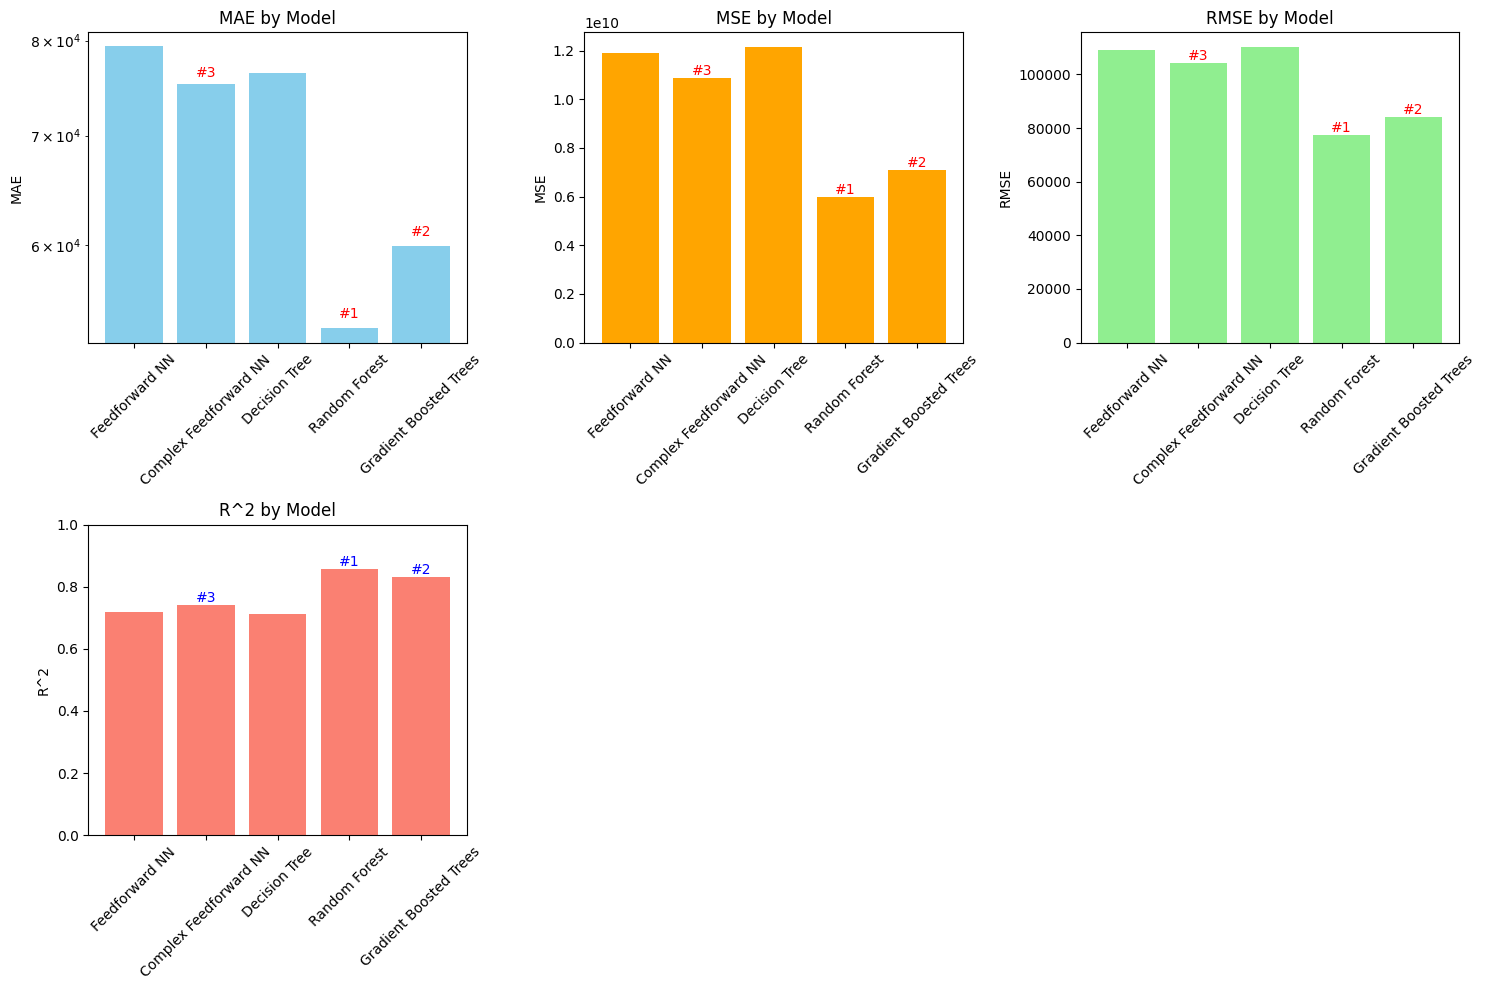

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Feedforward NN', 'Complex Feedforward NN', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']
mae_values = [79341.17329635085, 75264.74416956725, 76393.50789773652, 53396.32435922488, 59975.245630103884]
mse_values = [11886895677.742262, 10871671624.660145, 12139715860.641914, 5970901416.02656, 7081399128.66369]
rmse_values = [109027.04103910306, 104267.30851355157, 110180.37874613571, 77271.60808490115, 84151.04948046512]
r2_values = [0.7179269757069509, 0.7420179853995934, 0.7119276167888475, 0.8583120214196953, 0.8319601919121309]

# Function to add annotations on the bars
def three_best(ax, values):
    sorted_indices = np.argsort(values)
    for i in range(3):
        idx = sorted_indices[i]
        ax.text(idx, values[idx] + (max(values) * 0.01), f'#{i+1}', color='red', ha='center')

# Plotting bar graphs
plt.figure(figsize=(15, 10))

# Subplot 1: MAE
axis1 = plt.subplot(2, 3, 1)
axis1.bar(models, mae_values, color='skyblue')
three_best(axis1, mae_values)
plt.ylabel('MAE')
plt.title('MAE by Model')
plt.yscale('log')
plt.xticks(rotation=45)

# Subplot 2: MSE
axis2 = plt.subplot(2, 3, 2)
axis2.bar(models, mse_values, color='orange')
three_best(axis2, mse_values)
plt.ylabel('MSE')
plt.title('MSE by Model')
plt.xticks(rotation=45)

# Subplot 3: RMSE
axis3 = plt.subplot(2, 3, 3)
axis3.bar(models, rmse_values, color='lightgreen')
three_best(axis3, rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE by Model')
plt.xticks(rotation=45)

# Subplot 4: R^2
axis4 = plt.subplot(2, 3, 4)
bars = axis4.bar(models, r2_values, color='salmon')
plt.ylabel('R^2')
plt.title('R^2 by Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Annotating the three highest R^2 values
sorted_indices = np.argsort(r2_values)[::-1]
for i in range(3):
    idx = sorted_indices[i]
    axis4.text(idx, r2_values[idx] + 0.01, f'#{i+1}', color='blue', ha='center')

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

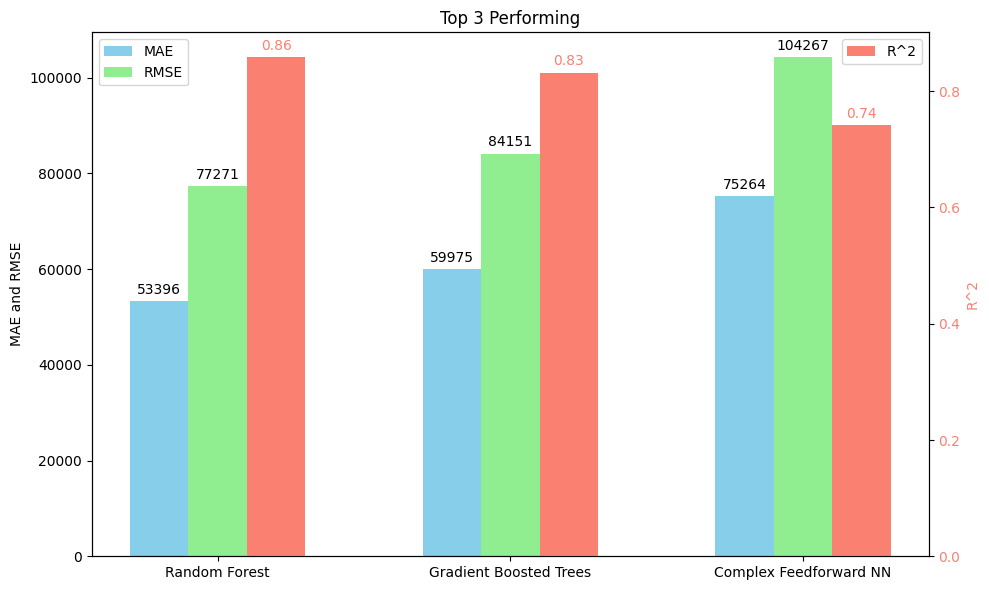

In [ ]:
import matplotlib.pyplot as plt

# Data for the three best preforming models
models = ['Random Forest', 'Gradient Boosted Trees', 'Complex Feedforward NN']
mae_values = [53396.32435922488, 59975.245630103884, 75264.74416956725]
mse_values = [5970901416.02656, 7081399128.66369, 10871671624.660145]
rmse_values = [77271.60808490115, 84151.04948046512, 104267.30851355157]
r2_values = [0.8583120214196953, 0.8319601919121309, 0.7420179853995934]

# Seting up a bar chart
x = np.arange(len(models))
width = 0.2

fig, axis1 = plt.subplots(figsize=(10, 6))
rects1 = axis1.bar(x - width, mae_values, width, label='MAE', color='skyblue')
rects2 = axis1.bar(x, rmse_values, width, label='RMSE', color='lightgreen')

# Creating secondary y-axis for R^2 values
axis2 = axis1.twinx()
rects3 = axis2.bar(x + width, r2_values, width, label='R^2', color='salmon')

# Adding labels, legend, and title
axis1.set_ylabel('MAE and RMSE', color='black')
axis1.set_xticks(x)
axis1.set_xticklabels(models)
axis1.legend(loc='upper left')

axis2.set_ylabel('R^2', color='salmon')
axis2.tick_params(axis='y', labelcolor='salmon')
axis2.legend(loc='upper right')

plt.title('Top 3 Performing')

# Annotating bars with their data values
for rect in rects1 + rects2:
    height = rect.get_height()
    axis1.annotate('{}'.format(int(height)),
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

for rect in rects3:
    height = rect.get_height()
    axis2.annotate('{:.2f}'.format(height),
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', color='salmon')

fig.tight_layout()
plt.show()

In [ ]:
%%writefile FinalGroupProject.py

Writing FinalGroupProject.py


In [ ]:
from google.colab import files
files.download('FinalGroupProject.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>